# Algebra and JAX <a href="https://colab.research.google.com/github/khipu-ai/practicals-2023/blob/main/notebooks/algebra_and_jax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<div align="center">
<img src="https://raw.githubusercontent.com/google/jax/main/images/jax_logo.png" width="25%" />
</div>

## Summary

In this tutorial, we will introduce how to perform numeric computations, in particular matrix computations, which are the basis of most Machine Learning algorithms. We'll begin with the basics using the de facto standard NumPy, and then move on to **JAX**. 

JAX is a new library that allows for very efficient speedups in the aforementioned operations by transparently choosing the best available hardware (CPU, GPU, TPU, etc.) and provinding with a number of acceleration and automation mechanisms such as automatic differentiation (`grad`), parallelization (`pmap`), vectorization (`vmap`) and just-in-time compilation (`jit`).

## Topics

* Numeric computation and linear algebra with NumPy
* Accelerated computation with JAX

## Objectives

* Learn to perform mathematical operations, in particular matrix operations in Python using  NumPy
* Learn the basics of JAX and its similarities and differences with NumPy
* Learn how to use JAX transforms - `jit`, `grad`, `vmap`, and `pmap`.

## Outline

1. [Introduction](#scrollTo=Enx0WUr8tIPf)
1. [Similarities between JAX and NumPy](#scrollTo=CbOEYsWQ6tHv)
1. [Differences between JAX and NumPy❌](#scrollTo=lg4__l4A7yqc)
1. [Acceleration in JAX 🚀](#scrollTo=TSj972IWxTo2)
1. [JAX is backend Agnostic](#scrollTo=_bQ9QqT-yKbs)
1. [JAX Transformations](#scrollTo=JM_08mXEBRIK)
1. [jit and grad](#scrollTo=cOGuGWtLmP7n)
1. [Pure Functions](#scrollTo=fT56qxXzTVKZ)
1. [vmap and pmap](#scrollTo=tvBzh8wiGuLf)

## Licence

* © Deep Learning Indaba 2022. Apache License 2.0.
* © Khipu 2023. Apache License 2.0.

## Version history

### 2022

* **Authors:** 
  * Kale-ab Tessera
  * Ignacio Ramírez (nacho@fing.edu.uy)
* **Reviewers:** 
  * Javier Antoran
  * James Allingham
  * Ruan van der Merwe
  * Sebastian Bodenstein
  * Laurence Midgley
  *  Joao Guilherme
  *  Elan van Biljon.   

# Before you start

For this practical, **you will need to use a GPU** to speed up training. 
To do this, go to the "Runtime" menu in Colab, select "Change runtime type" and then in the popup menu, choose "GPU" in the "Hardware accelerator" box.



## Installation and Imports

In [1]:
## Install and import anything required. Capture hides the output from the cell.
# @title Install and import required packages. (Run Cell)

import os

# https://stackoverflow.com/questions/68340858/in-google-colab-is-there-a-programing-way-to-check-which-runtime-like-gpu-or-tpu
if int(os.environ["COLAB_GPU"]) > 0:
    print("a GPU is connected.")
elif "COLAB_TPU_ADDR" in os.environ and os.environ["COLAB_TPU_ADDR"]:
    print("A TPU is connected.")
    import jax.tools.colab_tpu

    jax.tools.colab_tpu.setup_tpu()
else:
    print("Only CPU accelerator is connected.")
    # x8 cpu devices - number of (emulated) host devices
    os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=8"

import jax
import jax.numpy as jnp
from jax import grad, jit, vmap, pmap

import matplotlib.pyplot as plt
import numpy as np

a GPU is connected.


In [2]:
# @title Helper Functions. (Run Cell)
import copy
from typing import Dict


def plot_performance(data: Dict, title: str):
    runs = list(data.keys())
    time = list(data.values())

    # creating the bar plot
    plt.bar(runs, time, width=0.35)

    plt.xlabel("Implementation")
    plt.ylabel("Average time taken (in s)")
    plt.title(title)
    plt.show()

    best_perf_key = min(data, key=data.get)
    all_runs_key = copy.copy(runs)

    # all_runs_key_except_best
    all_runs_key.remove(best_perf_key)

    for k in all_runs_key:
        print(
            f"{best_perf_key} was {round((data[k]/data[best_perf_key]),2)} times faster than {k} !!!"
        )

# Matrix computations with NumPy

Below we introduce the basics of matrix and array manipulation and operation using the _de facto_ Python library for this task: NumPy. Feel free to skip if you are already familiar with all of this.

In Python/Numpy, `array` objects generalize the concept of a (numeric) _matrix_ to any number of dimensions: vectors are _one-dimensional arrays_, in the sense that they are indexed by one single index. Matrices, in turn, are _two-dimensional arrays_, since we need two indexes to specify an element. In general, an N-dimensional array requires N indexes to specify any given value within it.

Note that _dimension_ in this context is not the algebraic dimension of the object (in the case of a vector, its size), but the number of indexes that are needed to specifg an element. Let's see some examples:

* A vector $x$ is specified as $x=(x_1,x_2,\ldots,x_n)$. If $x_i \in \mathbb{R}$, we say that the vector $x \in \mathbb{R}^n$.
* A $2{\times}2$ matrix $A$ is given by
$$\left(\begin{array}{cc}a_{11}&a_{12}\\a_{21}&a_{22}\end{array}\right).$$
As an algebraic object, an $m{\times}n$ matrix with real entries belongs to the space $\mathbb{R}^{m{\times}n}$.
* The algebraic generalization of a matrix to objects with $N$ indexes is known as a _tensor_. For example, an $m{\times}n{\times}p$ tensor is given by $T=\{t_{ijk}: 1 \leq i \leq m, 1 \leq j \leq n, 1 \leq k \leq k\}$

Although not part of the Python distribution, `NumPy` is the de-facto standard for matrix and tensor manipulation and operations, along with a large number of utilities including random number generation, basic statistics, linear transformations, and many more.

Below we give a quick overview of the core NumPy interface, along with some basic Linear Algebra definitions.

## Creation and basic access


In [3]:
import numpy as np

print('CREATION\n')
#
# 1. CREATION
#
x = np.array([1,2,3])
print('x:',x)

#
# create a 2D array (a matrix):
# the data is specified as a list of rows, all of the same size
# each row is itself a list (or a tuple)
#
A = np.array( [ [3,4,5], [6,7,8], [9, 10, 11]] )
print('A:\n',A)

#
# we can also do this with a  tuple of tuples
#
B = np.array( ( (3,4,5), (6,7,8), (9,10,11) ) )
print('\nB:\n',A)
print()

#
# SINGLE ELEMENT ACCESS
#
print('\n\nREADING\n')

# in Python, array indexes begin at 0
# so, the first element of a three element vector x is x[0], and the last is x[2]
#
print('first element of x:',x[0])
print('last element of x:',x[2])
#
# Numpy follows the same indexing convention as Python, allowing us to acces elements
# from end to start using negative indices. For example, the last element of x
# can also be accessed as:
#
print('last element of x:',x[-1]) # notice it 'starts with' -1
print('next-to-last element of x:',x[-2]) # notice it 'starts with' -1
#
# for matrices, we need to specify two indexes
# the top-left element of a matrix has both indexes 0
#
print('top-left element of A:',A[0,0])
print('bottom-right element of A:',A[-1,-1])
#
# WRITING A SINGLE VALUE
#
print('\n\nWRITING\n')
A = np.array( [ [3,4,5], [6,7,8], [9, 10, 11]] )
print('A before:\n',A)
A[1,1] = 0
print('\nA after changing a single value:\n',A)


CREATION

x: [1 2 3]
A:
 [[ 3  4  5]
 [ 6  7  8]
 [ 9 10 11]]

B:
 [[ 3  4  5]
 [ 6  7  8]
 [ 9 10 11]]



READING

first element of x: 1
last element of x: 3
last element of x: 3
next-to-last element of x: 2
top-left element of A: 3
bottom-right element of A: 11


WRITING

A before:
 [[ 3  4  5]
 [ 6  7  8]
 [ 9 10 11]]

A after changing a single value:
 [[ 3  4  5]
 [ 6  0  8]
 [ 9 10 11]]


## Element types

NumPy can handle several types of elements. This is specified using the `dtype` optional argument at creation time. otherwise, the default `float64` type is used.

In [4]:
Afloat = np.ones((2,3))
print('A matrix of real-valued ones (notice the decimal dot)\n',Afloat)
Aint = np.ones((2,3),dtype=int)
print('A matrix of integer-valued ones\n',Aint)
Abool = np.ones((2,3),dtype=bool)
print('A matrix of boolean-valued ones\n',Abool)
Abyte  = np.ones((2,3),dtype=np.uint8)
print('A matrix of 8 bit unsigned integers, again all ones\n',np.uint8) # this is a custom NumPy type, not built in in Python
#
# beware the semantics!!
#
print('\nnegated boolean\n',~Abool)
print('\nnegated bytes\n',~Abyte)
print('\nsigned integer matrix - 10\n',Aint-10) 
print('\nunsigned 8 bit matrix - 10\n',Abyte-10) # this is NOT -9! Why?


A matrix of real-valued ones (notice the decimal dot)
 [[1. 1. 1.]
 [1. 1. 1.]]
A matrix of integer-valued ones
 [[1 1 1]
 [1 1 1]]
A matrix of boolean-valued ones
 [[ True  True  True]
 [ True  True  True]]
A matrix of 8 bit unsigned integers, again all ones
 <class 'numpy.uint8'>

negated boolean
 [[False False False]
 [False False False]]

negated bytes
 [[254 254 254]
 [254 254 254]]

signed integer matrix - 10
 [[-9 -9 -9]
 [-9 -9 -9]]

unsigned 8 bit matrix - 10
 [[247 247 247]
 [247 247 247]]


### Creating some useful matrices

Numpy includes functions for creating some commonly occuring matrices.
The semantics are some times confusing because the basic matrix creation functions expect a _single_ argument which is a tuple with the specified dimensions. However, there are some Numpy functions that take two arguments of the form `nrows,ncols`. We'll see about this later.

In [5]:
Z = np.zeros((10,4)) # the argument is a SINGLE TUPLE with the dimensions
# Z = np.zeros(10,4) # THIS DOES NOT WORK! 
print('all zeroes\n',Z)

O = np.ones( (5,5))
print('\nall ones\n',O)

I = np.eye(6) # this is always square, so only one dimension is needed
print('\nidentity (eye)\n',I)

x = (1,2,3,4)
D = np.diag(x) 
print('\ndiagonal\n',D)


all zeroes
 [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

all ones
 [[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]

identity (eye)
 [[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]

diagonal
 [[1 0 0 0]
 [0 2 0 0]
 [0 0 3 0]
 [0 0 0 4]]


## Copying, shallow and deep

One of the main culprits of obscure bugs for the inexperienced is when the semantics do not work as one would expect. 

Copying in Numpy, as in many libraries which handle possibly large objects, is by default a _shallow_ operation. This means that the statement `B=A` does not create a duplicate of `A`. Instead, `B` is just another handle/reference to the same data as `A`. A deep copy, where a new independent object is created, has to be done explicitly via functions.

Still more trouble: there are _many_ other operations which do not create new data. As a general rule, everything that just reorders the matrix in a simple way (not an arbitrary permutation) will keep the same data. This includes _slicing_, _transposing_, _reshaping_ and _flattening_. We'll see about this later.


In [6]:
#
# shallow copy
#
A = np.array( [ [3,4,5], [6,7,8], [9, 10, 11]] )
B = A
A[1,1] = 33
print('SHALLOW COPY\n')
print('A:\n',A)
print('B = A\n',B)
#
# deep copy, new object
#
B = np.copy(A)
A[1,1] = 1000
print('\n\nDEEP COPY\n')
print('A:\n',A)
print('B (deep):\n',B)
#
# deep copy into existing matrix (needs to be compatible!)
#
# this is very useful for saving memory and speeding up code!! 
#
np.copyto(B,A) # order is: destination, source
print('A:\n',A)
print('B after copyto:\n',B)


SHALLOW COPY

A:
 [[ 3  4  5]
 [ 6 33  8]
 [ 9 10 11]]
B = A
 [[ 3  4  5]
 [ 6 33  8]
 [ 9 10 11]]


DEEP COPY

A:
 [[   3    4    5]
 [   6 1000    8]
 [   9   10   11]]
B (deep):
 [[ 3  4  5]
 [ 6 33  8]
 [ 9 10 11]]
A:
 [[   3    4    5]
 [   6 1000    8]
 [   9   10   11]]
B after copyto:
 [[   3    4    5]
 [   6 1000    8]
 [   9   10   11]]


## Block access - Slicing

Like the name implies, _slicing_ is the process whereby one takes a piece of a matrix and handles it separately. This of course is extremely useful. One can extract rows, columns or blocks using the semantics we show below.

### Slicing and shallow/deep access

A _very_ important aspect to remember: slicing **is a shallow operation**. You still need to make a deep copy if you don't want to change the original matrix!

In [7]:
#
# we can cut chunks of vectors and matrices by specifying ranges
#
# 
print('\n\nSLICING\n')

x_sub = x[0:2] # first two elements of x
x_sub = x[:2] # exactly equivalent; the 0 may be ommited
x_sub = x[1:3] # last two elements of x 
x_sub = x[1:] # again, last index may be ommited
x_sub = x[-2:] # last two elements, using negative indexes!
print('subvector of x:',x_sub)
x_fakesub = x[:] # this is 'all' the elements of x = x
print('fakesub of x:',x_fakesub)

#
# matrix slicing
#
Asub = A[1:,1:] # lower-right 2x2 block of A
print('Asub')

# -----------------------------------------------------------
# EXCERSISE: 
# extract the 2x2 submatrix of A using negative indexes!
#  
print('\n\nEXCERSISE 1')

#
#
#-------------------------------------------------------------

#
# extracting rows and columns
#
# we saw that [:] means 'all the indexes'
# then, if we specify an index for a row, and ':' for columns,
# we get the entire row:
Arow2 = A[1,:]
# and if we want, for example, the first column:
Acol1 = A[:,0]
print('\nsecond row of A:\n',Arow2)
print('\nfirst column of A:\n',Acol1)
# -----------------------------------------------------------
# EXCERSISE: 
# extract the last row of A using negative indexes
#  
print('\n\nEXCERSISE 2')

#
#
#-------------------------------------------------------------
#
# WRITING MULTIPLE ELEMENTS
#
print('\n\nWRITING TO SLICES\n')
A[:,1] = 33
print('A after setting many values:\n',A)
#
# pasting other data
#
a = np.array( (44,44) )
A[0,1:3] = a
print('A after pasting a vector:\n',A)
#
# slicing does NOT create new data!!
#
Asub = A[:2,:2]
print('Taking a slice of A:\n',Asub)
Asub[:,:] = 0 # set all elements to 0
print('Slice, after zeroing:\n',Asub)
print('A after zeroing the slice:\n',A)




SLICING

subvector of x: (3, 4)
fakesub of x: (1, 2, 3, 4)
Asub


EXCERSISE 1

second row of A:
 [   6 1000    8]

first column of A:
 [3 6 9]


EXCERSISE 2


WRITING TO SLICES

A after setting many values:
 [[ 3 33  5]
 [ 6 33  8]
 [ 9 33 11]]
A after pasting a vector:
 [[ 3 44 44]
 [ 6 33  8]
 [ 9 33 11]]
Taking a slice of A:
 [[ 3 44]
 [ 6 33]]
Slice, after zeroing:
 [[0 0]
 [0 0]]
A after zeroing the slice:
 [[ 0  0 44]
 [ 0  0  8]
 [ 9 33 11]]


## Adding and removing rows/columns

There are two ways in which you can change a matrix: either you add/remove columns/rows, or you reshape it.

There is a large difference between these two groups of operations. NumPy does not add or delete stuff from a matrix _in place_. When you do so, a new array is returned _always_.

On the other hand, changing the shape without changing the total number of elements does not create new data, but just a new _view_ to that data.


In [8]:
#
# ADDING AND REMOVING ROWS/COLUMNS
#
#
# deleting is _not_ a common operation
# in matrix manipulation. 
#
# 'delete' a row: A is unchanged!
#
A = np.eye(4)
print('A before deleting the third row\n',A)
B = np.delete(A,2,axis=0) # axis: 0 means 'a row', 1 means 'a column'
print('A after deleting the third row\n',A)
print('B after deleting the third row\n',B)
#
# insertion: same thing: A is unchanged
#
# arguments: source matrix, where, what and which axis
#
B = np.insert(A,0, np.zeros((4)),axis=1) 
print('A after inserting a column of zeroes to the left\n',A)
print('B after inserting a column of zeroes to the left\n',B)
#
# append: insert at the end 
# this is actually tricky: the number of dimensions of the object appended
# must match those of the source matrix, and the shapes along those dimensions
# (with the except of the specified axis) must be the same too
#
print(np.ones(4)) # a flat vector (one dimension)
# B = np.append(A,np.ones((4)),axis=0) # DOES NOT WORK: source has two dimensions (matrix)
# B = np.append(A,np.ones((4,1)),axis=1) # DOES NOT WORK: shapes not compatible
B = np.append(A,np.ones((4,1)),axis=1) # WORKS: source has two dimensions (matrix)

print('A after appending a column of ones\n',A) # as always, A does not change
print('B after appending a column of ones\n',B)
#
# you can remove/insert/append  slices too
#
B = np.append(A,np.ones((4,3)),axis=1) # add three columns
print('B after appending three columns of ones\n',B)
#
# CONCATENATION
# 
# you can concatenate any number of matrices along a given axis
# remember: axis=0 means 'rows' and axis=1 means 'columns'
# so if you want to concatenate side by side, it is axis=1
# if you want to stack one above the other, it is axis=0
A = np.zeros((5,3)) # same number of columns
B = np.ones((4,3))
print('\nCONCATENATION\n')
print('A\n',A,'B\n',B)
source_matrices_tuple = (A,B) # needs to be a tuple
# AB = np.concatenate(source_matrices_tuple, axis=1) # DOES NOT WORK: not the same number of rows!
AB = np.concatenate(source_matrices_tuple, axis=0) # WORKS: same number of columns
print('A over B\n',AB)


A before deleting the third row
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
A after deleting the third row
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
B after deleting the third row
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]]
A after inserting a column of zeroes to the left
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
B after inserting a column of zeroes to the left
 [[0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]
[1. 1. 1. 1.]
A after appending a column of ones
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
B after appending a column of ones
 [[1. 0. 0. 0. 1.]
 [0. 1. 0. 0. 1.]
 [0. 0. 1. 0. 1.]
 [0. 0. 0. 1. 1.]]
B after appending three columns of ones
 [[1. 0. 0. 0. 1. 1. 1.]
 [0. 1. 0. 0. 1. 1. 1.]
 [0. 0. 1. 0. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1.]]

CONCATENATION

A
 [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]] B
 [[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]
A over B
 [

## Raveling, reshaping, transposing and flipping

You can change the way elements are shown without changing the data itself. In other words, these are **shallow** operations which create _views_ to the original data.

When reshaping, one must understand how the data is stored in memory. NumPy follows the so called 'C' ordering of matrices, also known as 'row major'. This means that the main (major) dimension is the row, and the secondary is the column. 

A good way to correctly predict the elements in the reshaped data is to first _flatten_ the data. This is actually one of the basic views, which can be obtained using the `ravel` operation.

Then, for any given shape that we may cast the original matrix to, the data will flow along the last dimension first, then the second to last, etc. This is much easier to see with examples.


In [9]:
#
# raveling
#
A = np.array([[1,2,3],[4,5,6]]) # 6 elements
print('A\n',A,'\nflattened A\n',A.ravel())
#
# reshaping
#

B = np.reshape(A,(3,2)) # reshaped must have the same number of elements!
print('\nreshaped to 3x2\n',B)
#
# transposing
#
B = np.transpose(A) # reshaped must have the same number of elements!
B = A.T # shortcut
print('\ntransposed \n',B)
B[2,1] = 0
print('\nzeroed an element in transposed \n',B)
print('\nshallow: A is also changed \n',A)
#
# flipping
#
B = np.fliplr(A) # reverse ordering of columns
print('\nA, columns reversed\n',B)
B[1,0] = 33
print('\nchanged B\n',B)
print('\nalso shallow: A is also changed \n',A)


A
 [[1 2 3]
 [4 5 6]] 
flattened A
 [1 2 3 4 5 6]

reshaped to 3x2
 [[1 2]
 [3 4]
 [5 6]]

transposed 
 [[1 4]
 [2 5]
 [3 6]]

zeroed an element in transposed 
 [[1 4]
 [2 5]
 [3 0]]

shallow: A is also changed 
 [[1 2 3]
 [4 5 0]]

A, columns reversed
 [[3 2 1]
 [0 5 4]]

changed B
 [[ 3  2  1]
 [33  5  4]]

also shallow: A is also changed 
 [[ 1  2  3]
 [ 4  5 33]]


## Masked access

Instead of specifying indexes, one may supply a binary mask of `0`s and `1`s and extract those elements where the mask s `1`. 
The values returned have two important properties: first, they are raveled (it is the only way to represent arbitrarily chosen elements from a matrix) and, second, they are still a **shallow** view of the original matrix!


In [10]:
#
# masking
#
A = np.array([[1,2,3],[4,5,6]]) # 6 elements
M = np.array([[1,0,0],[0,1,0]],dtype=bool) # binary mask
print('A\n',A,'\nmask\n',M)
print('elements of A extracted by the mask (raveled!)\n',A[M])
A[M]=1000
print('change masked elements: this is also a shallow operation!\n',A)


A
 [[1 2 3]
 [4 5 6]] 
mask
 [[ True False False]
 [False  True False]]
elements of A extracted by the mask (raveled!)
 [1 5]
change masked elements: this is also a shallow operation!
 [[1000    2    3]
 [   4 1000    6]]


## Matrix-Vector Algebra

Here we will see how to perform matrix-matrix and matrix-vector products.
Care must also be taken: the operator `*` is _not_ for these tasks! There are special functions and operations for performing algebraic operations. We'll see this below.


In [11]:
#
#
#
A = np.array([[1,-1,0],[-1,1,0],[0,1,-1],[0,-1,1]])
x = np.array([1,4,9])
print('A\n',A,'\nx\n',x)
#
# this is _not_ a dot product. What does it do?
#
print('\nx * x\n', x * x)
print('\nA * x\n', A * x)
#
# this is a dot product
#
print('\nAx\n',A @ x)
print('\n<x,x>\n', x @ x)
print('\n<x,x>\n', x @ x.T) # for vectors, its always the _inner_ product
print('\n<x,x>\n', x.T @ x) # transposition does not count
#
# old (but safest), using functions
#
print('\nAx\n',np.dot(A,x))
print('\nxtx\n',np.dot(x,x))
# print('\nAx\n',np.dot(A,A)) DOES NOT WORK!  Why?
print('\nAAt\n',np.dot(A,A.T)) # for matrices, transposition _counts_


A
 [[ 1 -1  0]
 [-1  1  0]
 [ 0  1 -1]
 [ 0 -1  1]] 
x
 [1 4 9]

x * x
 [ 1 16 81]

A * x
 [[ 1 -4  0]
 [-1  4  0]
 [ 0  4 -9]
 [ 0 -4  9]]

Ax
 [-3  3 -5  5]

<x,x>
 98

<x,x>
 98

<x,x>
 98

Ax
 [-3  3 -5  5]

xtx
 98

AAt
 [[ 2 -2 -1  1]
 [-2  2  1 -1]
 [-1  1  2 -2]
 [ 1 -1 -2  2]]


## Matrix and vector norms

There is a sub-package of NumPy for this called `linalg`. There you'll find many advanced algebraic operations including norms, condition numbers, inverses, solving linear systems, QR, SVD, Cholesky, etc.


In [12]:
import numpy.linalg as la 

A = np.array([[1,-1,0],[-1,1,0],[0,1,-1],[0,-1,1]])
x = np.array([1,4,9])
print('||x||_2:',la.norm(x)) # L2 norm
print('||A||_F:',la.norm(A)) # default: Frobenius norm: norm of the 'unrolled' matrix as a vector
print('||A||_F (again):',la.norm(A,'fro')) # explicitly say we want the frobenius (always good idea)
print('||A||_2 (nuclear):',la.norm(A,'nuc')) # nuclear or spectral norm
A = 4*np.eye(4)
print('A\n',A,'\ninv(A)\n',la.inv(A)) # must be square, of course

||x||_2: 9.899494936611665
||A||_F: 2.8284271247461903
||A||_F (again): 2.8284271247461903
||A||_2 (nuclear): 3.8637033051562732
A
 [[4. 0. 0. 0.]
 [0. 4. 0. 0.]
 [0. 0. 4. 0.]
 [0. 0. 0. 4.]] 
inv(A)
 [[0.25 0.   0.   0.  ]
 [0.   0.25 0.   0.  ]
 [0.   0.   0.25 0.  ]
 [0.   0.   0.   0.25]]


## Other NumPy functions

Besides matrices and algebra, NumPy brings many useful utilities. A particularly useful one is the package `numpy.random` which implements high quality pseudo-random number generators, and many functions, for example:

* drawing random samples from various distributions
* random subsamples of sets
* random permutations


In [13]:
import numpy.random as rand

#
# extremely important for reproducible research: set the seed!
#
rng = rand.default_rng(12345) 
#
# draw some Normal samples
#
print('A 3x2 random with normal(0,1) samples\n',rng.normal(size=(3,2)))
#
# very useful function for creating ranges, linear and logarithmic
#
x = np.arange(10)
print('\nx',x)
print('random permutation of x',rng.permutation(x))
print('random subsample of x',rng.choice(x,4))

A 3x2 random with normal(0,1) samples
 [[-1.42382504  1.26372846]
 [-0.87066174 -0.25917323]
 [-0.07534331 -0.74088465]]

x [0 1 2 3 4 5 6 7 8 9]
random permutation of x [0 8 3 7 2 6 9 5 4 1]
random subsample of x [4 0 8 4]


We are done with the basics of NumPy. Of course there is a lot more. Check out the official [Numpy API](https://numpy.org/doc/stable/reference/index.html) to see what's there.

We will now move onto JAX. JAX has two purposes: on one side, it provides a backend-transparent accelerated linear algebra interface which can run on specialized hardware such as GPUs and TPUs.

It also provides _transformations_ for, example, parallel execution, or just-in-time compilation for maximum speed.



# JAX

[JAX](https://jax.readthedocs.io/en/latest/index.html) is a python package for writing composable numerical transformations. It leverages [Autograd](https://github.com/hips/autograd) and [XLA](https://www.tensorflow.org/xla) (Accelerated Linear Algebra), to achieve high-performance numerical computing, which is particularly relevant in machine learning.

It provides functionality such as automatic differentiation (`grad`), parallelization (`pmap`), vectorization (`vmap`), just-in-time compilation (`jit`), and more. These transforms operate on [pure functions](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#pure-functions), so JAX encourages a **functional programming** paradigm. Furthermore, the use of XLA  allows one to target different kinds of accelerators (CPU, GPU and TPU), without code changes.  

JAX is different from frameworks such as PyTorch or Tensorflow (TF). It is more low-level and minimalistic. JAX simply offers a set of primitives (simple operations) like `jit` and `vmap`, and relies on other libraries for other things e.g. using the data loader from PyTorch or TF. Due to JAX's simplicity, it is commonly used with higher-level neural network libraries such as [Haiku](https://github.com/deepmind/dm-haiku) or [Flax](https://github.com/google/flax). (Imagine writing complicated architectures using a NumPy-like interface alone! 😮 )   

In [14]:
## @title Check the device you are using (Run Cell)
print(f"Num devices: {jax.device_count()}")
print(f" Devices: {jax.devices()}")

Num devices: 1
 Devices: [GpuDevice(id=0, process_index=0)]


# JAX vs NumPy 

## Similarities  🤝

The main similarity between JAX and NumPy is that they share a similar interface and often, JAX and NumPy arrays can be used interchangeably. 

## Similiar Interface

Let's plot the sine functions using NumPy.

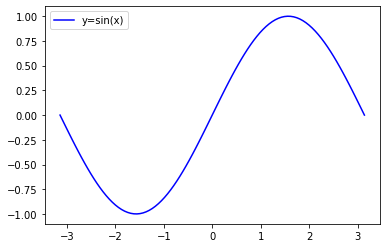

In [15]:
# 100 linearly spaced numbers from -np.pi to np.pi
x = np.linspace(-np.pi, np.pi, 100)

# the function, which is y = sin(x) here
y = np.sin(x)

# plot the functions
plt.plot(x, y, "b", label="y=sin(x)")

plt.legend(loc="upper left")

# show the plot
plt.show()

Now using jax. We already imported `jax.numpy` as `jnp` in the first cell.

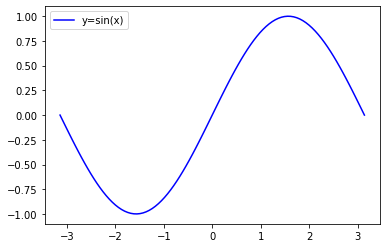

In [16]:
# 100 linearly spaced numbers from -jnp.pi to jnp.pi
x = jnp.linspace(-jnp.pi, jnp.pi, 100)

# the function, which is y = sin(x) here
y = jnp.sin(x)

# plot the functions
plt.plot(x, y, "b", label="y=sin(x)")

plt.legend(loc="upper left")

# show the plot
plt.show()

**Exercise 1.1 - Code Task:** Can you plot the cosine function using `jnp`?

TypeError: ignored

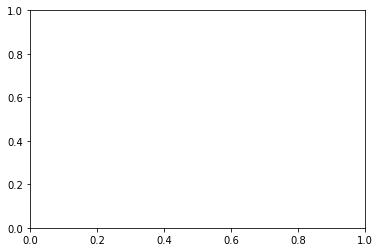

In [17]:
# Plot Cosine using jnp. (UPDATE ME)

# 100 linearly spaced numbers
# UPDATE ME
x = ...

# UPDATE ME
y = ...


# plot the functions
plt.plot(x, y, "b", label="y=cos(x)")

plt.legend(loc="upper left")

# show the plot
plt.show()

In [ ]:
# @title Answer to code task (Try not to peek until you've given it a good try!')
# 100 linearly spaced numbers
x = jnp.linspace(-jnp.pi, jnp.pi, 100)

y = jnp.cos(x)

# plot the functions
plt.plot(x, y, "b", label="y=cos(x)")

plt.legend(loc="upper left")

# show the plot
plt.show()

## Differences


## JAX arrays are immutable, NumPy arrays are not

JAX and NumPy arrays are often interchangeable, **but** Jax arrays are **immutable** (they can't be modified after they are created). Allowing mutations makes transforms difficult and violates conditions for [pure functions](https://en.wikipedia.org/wiki/Pure_function).



### NumPy

Let's see this in practice by changing the number at the beginning of an array. 

In [ ]:
# NumPy: mutable arrays
x = np.arange(10)
x[0] = 10
print(x)

### JAX

In [ ]:
# JAX: immutable arrays
# Should raise an error.
try:
    x = jnp.arange(10)
    x[0] = 10
except Exception as e:
    print("Exception {}".format(e))

So it fails! We can't mutate a JAX array once it has been created. To update JAX arrays, we need to use [helper functions](https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html) that return an updated copy of the JAX array. 

Instead of doing this `x[idx] = y`, we need to do this `x = x.at[idx].set(y)`. 

In [ ]:
x = jnp.arange(10)
new_x = x.at[0].set(10)
print(f" new_x: {new_x} original x: {x}")

Note here that `new_x` is a copy and that the original `x` is unchanged. 

## Random number generation in NumPy and JAX 

JAX is more explicit in Pseudo Random Number Generation (PRNG) than `NumPy` and other libraries (such as `TensorFlow` or `PyTorch`). [PRNG](https://en.wikipedia.org/wiki/Pseudorandom_number_generator) is the process of algorithmically generating a sequence of numbers, which *approximate* the properties of a sequence of random numbers.  

Let's see the differences in how JAX and NumPy generate random numbers.

##### In Numpy, PRNG is based on a global `state`.

Let's set the initial seed.

In [ ]:
# Set random seed
np.random.seed(42)
prng_state = np.random.get_state()

In [ ]:
# @title Helper function to compare prng keys (Run Cell)
def is_prng_state_the_same(prng_1, prng_2):
    """Helper function to compare two prng keys."""
    # concat all elements in prng tuple
    list_prng_data_equal = [(a == b) for a, b in zip(prng_1, prng_2)]
    # stack all elements together
    list_prng_data_equal = np.hstack(list_prng_data_equal)
    # check if all elements are the same
    is_prng_equal = all(list_prng_data_equal)
    return is_prng_equal

Let's take a few samples from a Gaussian (normal) Distribution and check if PRNG keys/global state change.

In [ ]:
print(
    f"sample 1 = {np.random.normal()} Did prng state change: {not is_prng_state_the_same(prng_state,np.random.get_state())}"
)
prng_state = np.random.get_state()
print(
    f"sample 2 = {np.random.normal()} Did prng state change: {not is_prng_state_the_same(prng_state,np.random.get_state())}"
)
prng_state = np.random.get_state()
print(
    f"sample 3 = {np.random.normal()} Did prng state change: {not is_prng_state_the_same(prng_state,np.random.get_state())}"
)

Numpy's global random state is updated every time a random number is generated, so *sample 1 != sample 2 != sample 3*. 

Having the state automatically updated, makes it difficult to handle randomness in a **reproducible** way across different threads, processes and devices. 

##### In JAX, PRNG is explicit.

In JAX, for each random number generation, you need to explicitly pass in a random key/state.

Passing the same state/key results in the same number being generated. This is generally undesirable.

In [ ]:
from jax import random

key = random.PRNGKey(42)
print(f"sample 1 = {random.normal(key)}")
print(f"sample 2 = {random.normal(key)}")
print(f"sample 3 = {random.normal(key)}")

To generate different and independent samples, you need to manually **split** the keys. 

In [ ]:
from jax import random

key = random.PRNGKey(42)
print(f"sample 1 = {random.normal(key)}")

# We split the key -> new key and subkey
new_key, subkey = random.split(key)

# We use the subkey immediately and keep the new key for future splits.
# It doesn't really matter which key we keep and which one we use immediately.
print(f"sample 2 = {random.normal(subkey)}")

# We split the new key -> new key2 and subkey
new_key2, subkey = random.split(new_key)
print(f"sample 3 = {random.normal(subkey)}")

By using JAX, we can more easily reproduce random number generation in parallel across threads, processes, or even devices by explicitly passing and keeping track of the prng key (without relying on a global state that automatically gets updated). For more details on PRNG in JAX, you can read more [here](https://jax.readthedocs.io/en/latest/jep/263-prng.html). 

# Acceleration in JAX 🚀

JAX leverages Autograd and XLA for accelerating numerical computation. The use of Autograd allows for automatic differentiation (`grad`), while XLA allows JAX to run on multiple accelerators/backends and run transforms like `jit` and `pmap`. JAX also allows you to use `vmap` for automatic vectorization.  

## JAX is backend Agnostic

Using JAX, you can run the same code on different backends/AI accelerators (e.g. CPU/GPU/TPU), **with no changes in code** (no more `.to(device)` - from frameworks like PyTorch). This means we can easily run linear algebra operations directly on GPU/TPU.

**Multiplying Matrices**

Dot products are a common operation in numerical computing and a central part of modern deep learning. They are defined over [vectors](https://en.wikipedia.org/wiki/Coordinate_vector), which can loosely be thought of as a list of multiple scalers (single values). 

Formally, given two vectors $\boldsymbol{x}$,$\boldsymbol{y}$ $\in R^n$, their dot product is defined as:

<center>$\boldsymbol{x}^{\top} \boldsymbol{y}=\sum_{i=1}^{n} x_{i} y_{i}$</center>

Dot Product in NumPy (will run on cpu)

In [ ]:
size = 1000
x = np.random.normal(size=(size, size))
y = np.random.normal(size=(size, size))
numpy_time = %timeit -o -n 10 a_np = np.dot(y,x.T)

Dot Product using JAX (will run on current runtime - e.g. GPU).

In [ ]:
size = 1000
key1, key2 = jax.random.split(jax.random.PRNGKey(42), num=2)
x = jax.random.normal(key1, shape=(size, size))
y = jax.random.normal(key2, shape=(size, size))
jax_time = %timeit -o -n 10 jnp.dot(y, x.T).block_until_ready()


> When timing JAX functions, we use `.block_until_ready()` because JAX uses [asynchronous dispatch](https://jax.readthedocs.io/en/latest/async_dispatch.html#async-dispatch). This means JAX doesn't wait for the operation to complete before returning control to your code. To fairly compute the time taken for JAX operations, we therefore block until the operation is done.



How much faster was the dot product in JAX (Using GPU)?

In [ ]:
np_average_time = np.mean(numpy_time.all_runs)
jax_average_time = np.mean(jax_time.all_runs)
data = {"numpy": np_average_time, "jax": jax_average_time}

plot_performance(data, title="Average time taken per framework to run dot product")

JAX not running much faster? -> Re-run the JAX cell.                       
> "Keep in mind that the first time you run JAX code, it will be slower because it is being compiled. T*his is true even if you don’t use jit in your own code, because JAX’s builtin functions are also jit compiled*." - [JAX Docs](https://jax.readthedocs.io/en/latest/faq.html#benchmarking-jax-code).

If you are running on an accelerator, you should see a considerable performance benefit of using JAX, without making any changes to your code! 







# JAX Transformations

JAX transforms (`jit`, `grad`, `vmap`, `pmap`) first convert python functions into an intermediate language called *jaxpr*. Transforms are then applied to this jaxpr representation.

JAX generates jaxpr, in a process known as **tracing**. During tracing, function inputs are wrapped by a tracer object and then JAX records all operations (including regular python code) that occur during the function call. These recorded operations are used to reconstruct the function. 

Any python side-effects are not recorded during tracing. JAX transforms and compilations are designed to work only with **pure functions**. For more on tracing and jaxpr, you can read [here](https://jax.readthedocs.io/en/latest/jaxpr.html).



## JIT (Just in Time) compilation

Jax dispatches operations to accelerators one at a time. If we have repeated operations, we can use `jit` to compile the function the first time it is called, then subsequent calls will be [cached](https://en.wikipedia.org/wiki/Cache_(computing) (save the compiled version so that it doesn't need to be recompiled everytime we call it). 

Let's compile [ReLU (Rectified Linear Unit)](https://arxiv.org/abs/1803.08375), a popular activation function in deep learning. 

ReLU is defined as follows:
<center>$f(x)=max(0,x)$</center>

It can be visualized as follows:

<center>
<img src="https://machinelearningmastery.com/wp-content/uploads/2018/10/Line-Plot-of-Rectified-Linear-Activation-for-Negative-and-Positive-Inputs.png" width="35%" />
</center>,

where $x$ is the input to the function and $y$ is output of ReLU.


$$f(x)=\max (0, x)=\left\{\begin{array}{l}x_{i} \text { if } x_{i}>0 \\ 0 \text { if } x_{i}<=0\end{array}\right.$$

**Exercise 1.2 - Code Task:** Complete the ReLU implementation below using standard python.

In [ ]:
# Implement ReLU.
def relu(x):
    if x > 0:
        return
        # TODO Implement me!
    else:
        return
        # TODO Implement me!

In [ ]:
# @title Run to test your function.


def plot_relu(relu_function):
    max_int = 5
    # Generete 100 evenly spaced points from -max_int to max_int
    x = np.linspace(-max_int, max_int, 1000)
    y = np.array([relu_function(xi) for xi in x])
    plt.plot(x, y, label="ReLU")
    plt.legend(loc="upper left")
    plt.xticks(np.arange(min(x), max(x) + 1, 1))
    plt.show()


def check_relu_function(relu_function):
    # Generete 100 evenly spaced points from -100 to -1
    x = np.linspace(-100, -1, 100)
    y = np.array([relu_function(xi) for xi in x])
    assert (y == 0).all()

    # Check if x == 0
    x = 0
    y = relu_function(x)
    assert y == 0

    # Generete 100 evenly spaced points from 0 to 100
    x = np.linspace(0, 100, 100)
    y = np.array([relu_function(xi) for xi in x])
    assert np.allclose(x, y)

    print("Your ReLU function is correct!")


check_relu_function(relu)
plot_relu(relu)

In [ ]:
# @title Answer to code task (Try not to peek until you've given it a good try!')
def relu(x):
    if x > 0:
        return x
    else:
        return 0


check_relu_function(relu)
plot_relu(relu)

Let's try to `jit` this function to speed up compilation and then try to call it.

In [ ]:
relu_jit = jax.jit(relu)

key = jax.random.PRNGKey(42)
# Gen 1000000 random numbers and pass them to relu
num_random_numbers = 1000000
x = jax.random.normal(key, (num_random_numbers,))

# Should raise an error.
try:
    relu_jit(x)
except Exception as e:
    print("Exception {}".format(e))

**Why does this fail?**


> As mentioned above, JAX transforms first converts python functions into an intermediate language called *jaxpr*. Jaxpr only captures what is executed on the parameters given to it during tracing, so this means during conditional calls, jaxpr only considers the branch taken.
> 
> When jit-compiling a function, we want to compile and cache a version of the function that can handle multiple different argument types (so we don't have to recompile for each function evaluation). For example, when we compile a function on an array `jnp.array([1., 2., 3.], jnp.float32)`, we would likely also want to use the compiled function for `jnp.array([4., 5., 6.], jnp.float32)`. 
> 
> To achieve this, JAX traces your code based on abstract values. The default abstraction level is a ShapedArray - array that has a fixed size and dtype, for example, if we trace a function using `ShapedArray((3,), jnp.float32)`,  it can be reused for any concrete array of size 3, and float32 dtype. 
> 
> This does come with some challenges. Tracing that relies on concrete values becomes tricky and sometimes results in `ConcretizationTypeError` as in the ReLU function above. Furthermore, when tracing a function with conditional statements ("if ..."), JAX doesn't know which branch to take when tracing and so tracing can't occur.

**TLDR**: JAX tracing doesn't work well with conditional statements ("if ..."). 



To solve this, we have two options:
- Use static arguments to make sure JAX traces on a concrete value level - this is not ideal if you need to retrace a lot. Example - bottom of this [section](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#python-control-flow-jit).
- Use builtin JAX condition flow primitives such as [`lax.cond`](https://jax.readthedocs.io/en/latest/_autosummary/jax.lax.cond.html) or [`jnp.where`](https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.where.html).  

**Exercise 1.3 - Code Task** : Let's convert our ReLU function above to work with jit.

**Useful methods:**  [`jnp.where`](https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.where.html) (or [`jnp.maximum`](https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.maximum.html), if you prefer.) 

In [ ]:
# Implement a jittable ReLU
def relu(x):
    # TODO Implement ME!
    return ...

In [ ]:
# @title Run to test your function.
check_relu_function(relu)

In [ ]:
# @title Answer to code task (Try not to peek until you've given it a good try!')
def relu(x):
    return jnp.where(x > 0, x, 0)
    # Another option - return jnp.maximum(x,0)


check_relu_function(relu)

In [ ]:
# @title Now let's see the performance benefit of using jit! (Run me)

# jit our function
relu_jit = jax.jit(relu)

# generate random input
key = jax.random.PRNGKey(42)
num_random_numbers = 1000000
x = jax.random.normal(key, (num_random_numbers,))

# time normal jit function
jax_time = %timeit -o -n 10 relu(x).block_until_ready()

# Warm up/Compile - first run for jitted function
relu_jit(x).block_until_ready()

# time jitted function
jax_jit_time = %timeit -o -n 10 relu_jit(x).block_until_ready()

# Let's plot the performance difference
jax_avg_time = np.mean(jax_time.all_runs)
jax_jit_avg_time = np.mean(jax_jit_time.all_runs)
data = {"JAX (no jit)": jax_avg_time, "JAX (with jit)": jax_jit_avg_time}

plot_performance(data, title="Average time taken for ReLU function")

## Automatic gradient computation

The `grad` transformation is used to automatically compute the gradient of a function in JAX. It can be applied to Python and NumPy functions, which means you can differentiate through loops, branches, recursion, and closures.  

`grad` takes in a function `f` and returns a function. If `f` is a mathematical function $f(x)$, then `grad(f(x))` corresponds to $f'(x)=\frac{df}{dx}$. Then `grad(f)(x_0)` yields $f'(x_0)$.


Let's take a simple function $f(x)=6x^4-9x+4$

In [ ]:
f = lambda x: 6 * x**4 - 9 * x + 4

We can compute the gradient of this function - $f'(x)$ and evaluate it at $x=3$.

In [ ]:
dfdx = grad(f)
dfdx_3 = dfdx(3.0)

**Exercise 1.4 - Math Task**: Can you calculate $f'(2)$ by hand?

In [ ]:
answer = 0  # @param {type:"integer"}

dfdx_2 = dfdx(2.0)

assert (
    answer == dfdx_2
), "Incorrect answer, hint https://en.wikipedia.org/wiki/Power_rule#Statement_of_the_power_rule"

print("Nice, you got the correct answer!")

In [ ]:
# @title Answer to math task (Try not to run until you've given it a good try!') 
%%latex                                                  
\begin{aligned}
f(x) & = 6x^4-9x+4 \\
f'(x) & = 24x^3 -9  && \triangleright \textrm{Power Rule.}  \\ 
f'(2) &  = 24(2)^3 -9 = 183 && \triangleright \textrm{Substituting x=2} \\
\end{aligned}

We can also chain `grad` to calculate higher order deratives. 

We can calculate $f'''(x)$ as follows:

In [ ]:
d3dx = grad(grad(grad(f)))

**Exercise 1.5 - Math Task**: How about $f'''(2)$ by hand?

In [ ]:
answer = 0  # @param {type:"integer"}

d3dx_2 = d3dx(2.0)

assert answer == d3dx_2, "Incorrect answer, hint ..."

print("Nice, you got the correct answer!")

In [ ]:
# @title Answer to math task (Try not to run until you've given it a good try!') 
%%latex 

\begin{aligned}
f(x) & = 6x^4-9x+4 \\
f'(x) & = 24x^3 -9  && \triangleright \textrm{Power Rule.}  \\
f''(x) & = 72x^2  && \triangleright \textrm{Power Rule.}  \\
f'''(x) & = 144x && \triangleright \textrm{Power Rule.} \\
f'''(2) & = 144(2)=288 && \triangleright \textrm{Substituting x=2} \\ 
\end{aligned}

Another useful method is `value_and_grad`, where we can get the value ($f(x)$) and gradient ($f'(x)$). 

In [ ]:
from jax import value_and_grad

f_x, dy_dx = value_and_grad(f)(2.0)
print(f"f(x): {f_x} f′(x): {dy_dx} ")

> For partial derivatives, you need to use the [`argnums`](https://jax.readthedocs.io/en/latest/_autosummary/jax.grad.html) param to specify which variables you want to differentiate with respect to. 



**Exercise 1.6 - Group Task:** Chat with neighbour/think about how JAX's automatic differentiation compares to other libraries such as Pytorch or Tensorflow. 

Another useful application related to `grad` is when you want your `grad` function to return auxiliary (extra) data, that you don't want differentiated. You can use the `has_aux` parameter to do this (example in "Auxiliary data" section in [here](https://github.com/google/jax/blob/main/docs/jax-101/01-jax-basics.ipynb)).

## Pure Functions

JAX transformation and compilation are designed to work reliably on **pure functions** (see [Wikipedia page on pure functions](https://en.wikipedia.org/wiki/Pure_function)). These functions have the following properties:
1. All **input** data is passed through the **function's parameters**. 
2. All **results** are output through the **function's return**. 
3. The function always returns the same **result** if invoked with the **same inputs**. What if your function involves randomness? Pass in the random seed!
4. **No [side-effects](https://en.wikipedia.org/wiki/Side_effect_(computer_science))** - no mutation of non-local variables or input/output streams.  
 

Let's see what could happen if we don't stick to using pure functions.

### Side Effects

Let's call print within a function.

In [ ]:
def impure_print_side_effect(x):
    print("Print me!")  # This is a side-effect
    return x


# The side-effects appear during the first run
print("First call: ", jax.jit(impure_print_side_effect)(4.0))

As expected, the print statement is called.

Let's call this function again. 

In [ ]:
# Subsequent runs with parameters of same type and shape may not show the side-effect
# This is because JAX now invokes a cached compilation of the function
print("Second call: ", jax.jit(impure_print_side_effect)(5.0))

Ah, no print statement! Since JAX cached the compilation of the function, `print()` calls will only happen during tracing and not every time the function is called. 

In [ ]:
# JAX re-runs the Python function when the type or shape of the argument changes
print(
    "Third call, different type: ", jax.jit(impure_print_side_effect)(jnp.array([5.0]))
)

In this case, we called the function with a different shaped object and so it triggered the re-tracing of the function and print was called again. 

To print values in compiled functions, use [host callbacks](https://jax.readthedocs.io/en/latest/jax.experimental.host_callback.html?highlight=print#jax.experimental.host_callback.id_print)([example](https://github.com/google/jax/issues/196#issuecomment-1191155679)) or if your jax version>=0.3.16, you can use [`jax.debug.print`](https://jax.readthedocs.io/en/latest/debugging/print_breakpoint.html). 


### Global variables

Using global variables can also lead to some undesired consequences!

In [ ]:
g = 0.0


def impure_uses_globals(x):
    return x + g


# JAX captures the value of the global during the first run
print("First call: ", jax.jit(impure_uses_globals)(4.0))

This prints 4, using the original value of `g`.

Let's update `g` and call our function again.

In [ ]:
g = 10.0  # Update the global

# Subsequent runs may silently use the cached value of the globals
print("Second call: ", jax.jit(impure_uses_globals)(4.0))

Even though we updated our global variable, this still prints 4, using the original value of `g`. This is because the value of `g` was cached.

In [ ]:
# JAX re-runs the Python function when the type or shape of the argument changes
# This will end up reading the latest value of the global
print("Third call, different type: ", jax.jit(impure_uses_globals)(jnp.array([4.0])))

Similar to the side-effects example, re-tracing gets triggered when the shape of our input has changed. In this case, our function now uses the updated value of `g`.

Since the global variables are cached, it is still okay to use global **constants** inside jax functions.

## Function vectorization with vmap

vmap (Vectorizing map) automatically vectorizes your python functions. 

Let's define a simple function that calculates the min and max of an input.

In [ ]:
def min_max(x):
    return jnp.array([jnp.min(x), jnp.max(x)])

We can apply this function to the vector - `[0, 1, 2, 3, 4]` and get the min and max values.

In [ ]:
x = jnp.arange(5)
min_max(x)

What about if we want to apply this to a batch/list of vectors (i.e. calculate the min and max independently across multiple batches)? 

Let's create our batch - 3 vectors of size 5.

In [ ]:
batch_size = 3
batched_x = np.arange(15).reshape((batch_size, -1))
print(batched_x)

**Exercise 1.7 - Question**: What do you think would be the result if we passed batch_x into `min_max`?

In [ ]:
batch_min_max_output = [[0,4],[5,9],[10,14]]  # @param ["[[0,4],[5,9],[10,14]]", "[[0,10],[1,11],[2,12],[3,13],[4,14]]", "[0,14]"] {type:"raw"}

assert (batch_min_max_output == np.array(min_max(batched_x))).all(), "Incorrect answer."

print("Nice, you got the correct answer!")

So the above is not what we want. The `min` and `max` is applied across the entire batch, when we want the min and max per vector/mini-batch. 

We can also manually batch this by `jnp.stack` and a for loop, as follows:

In [ ]:
@jit
def manual_batch_min_max_loop(batched_x):
    min_max_result_list = []
    for x in batched_x:
        min_max_result_list.append(min_max(x))
    return jnp.stack(min_max_result_list)


print(manual_batch_min_max_loop(batched_x))

Or, just manually updating the `axis` in `jnp.min` and `jnp.max`. 

In [ ]:
@jit
def manual_batch_min_max_axis(batched_x):
    return jnp.array([jnp.min(batched_x, axis=1), jnp.max(batched_x, axis=1)]).T


print(manual_batch_min_max_axis(batched_x))

These approaches both work, but we need to change our function to work with batches. We can't just run the same code across a batch of data.

There is where `vmap` becomes useful! Using `vmap` we can write a function once, as if it is working on a single element, and then use `vmap` to automatically vectorize it! 

In [ ]:
# define our vmap function using our original single vector function
@jit
def min_max_vmap(batched_x):
    return vmap(min_max)(batched_x)


# Run it on a single vecor
## We add extra dimention in a single vector, shape changes from (5,) to (1,5), which makes the vmapping possible
x_with_leading_dim = jax.numpy.expand_dims(x, axis=0)
print(f"Single vector: {min_max_vmap(x_with_leading_dim)}")

# Run it on batch of vectors
print(f"Batch/list of vector:{min_max_vmap(batched_x)}")

So this is really convenient, but what about performance? 

In [ ]:
batched_x = np.arange(50000).reshape((500, 100))

# Trace the functions with first call
manual_batch_min_max_loop(batched_x).block_until_ready()
manual_batch_min_max_axis(batched_x).block_until_ready()
min_max_vmap(batched_x).block_until_ready()

min_max_forloop_time = %timeit -o -n 10 manual_batch_min_max_loop(batched_x).block_until_ready()
min_max_axis_time = %timeit -o -n 10 manual_batch_min_max_axis(batched_x).block_until_ready()
min_max_vmap_time = %timeit -o -n 10 min_max_vmap(batched_x).block_until_ready()

print(
    f"Avg Times (lower is better) - Naive Implementation: {np.round(np.mean(min_max_forloop_time.all_runs),5)} Manually Vectorized: {np.round(np.mean(min_max_axis_time.all_runs),5)} Vmapped Function: {np.round(np.mean(min_max_vmap_time.all_runs),5)} "
)

So `vmap` should be similar in performance to manually vectorized code (if everything is implemented well), and much better than naively vectorized code (i.e. for loops). 

## Paralelization with pmap

💡**For this subsection, please ensure that colab is using a `TPU` runtime. If no `TPU` runtimes are available, select `Harware Accelerator` - `None` for a cpu runtime.** 

With `pmap` we can convert a function written for a single device to a function that can run in parallel across many devices. 

**Difference between `vmap` and `pmap`**:

So both `pmap` and `vmap` transform a function to work over an array, but they differ in implementation. `vmap` adds an extra batch dimension to all the operations in a function, while `pmap` replicates the function and executes each replica on its own XLA device in parallel.

In [ ]:
# @title Check the device you are using (Run Cell)
print(f"Num devices: {jax.device_count()}")
print(f" Devices: {jax.devices()}")

Let's try and `pmap` a batch of dot products.

Here is an illustration of how we would typically do this sequentially: 

[Source](https://www.assemblyai.com/blog/why-you-should-or-shouldnt-be-using-jax-in-2022/)

In [ ]:
# @title Illustration of Sequential Dot Product (Run me)
from IPython.display import HTML

HTML(
    '<iframe width="560" height="315" src="https://www.assemblyai.com/blog/content/media/2022/02/not_parallel-2.mp4" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>'
)

Here is the code implementation of this:

In [ ]:
# Let's generate a batch of size 8, each with a matrix of size (500, 600)

# Let create 8 keys, 1 for each batch
keys = jax.random.split(jax.random.PRNGKey(0), 8)

# Let create our batches
mats = jnp.stack([jax.random.normal(key, (500, 600)) for key in keys])


def dot_product_sequential():
    @jit
    def avg_dot_prod(mats):
        result = []
        # Loop through batch and compute dp
        for mat in mats:
            # dot product between the a mat and mat.T (transposed version)
            result.append(jnp.dot(mat, mat.T))
        return jnp.stack(result)

    avg_dot_prod(mats).block_until_ready()


run_sequential = %timeit -o -n 5 dot_product_sequential()

Here is an illustration of how we would do this in parallel 

[Source](https://www.assemblyai.com/blog/why-you-should-or-shouldnt-be-using-jax-in-2022/)

In [ ]:
# @title Illustration of Parallel Dot Product (Run me)
from IPython.display import HTML

HTML(
    '<iframe width="560" height="315" src="https://www.assemblyai.com/blog/content/media/2022/02/parallelized.mp4" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>'
)

Here is code implementation of batched dot products:

First, we will create `8` random matrices (one for each available tpu devices - colab tpu's have 8 available [devices](https://cloud.google.com/tpu/docs/system-architecture-tpu-vm) or the 8 cpu cores as we configured).

In [ ]:
# Let create 8 keys, 1 for each batch
keys = jax.random.split(jax.random.PRNGKey(0), 8)

# Each replicated pmapped function get a different key
mats = pmap(lambda key: jax.random.normal(key, (500, 600)))(keys)

The leading dimension here needs to equal the dimension of available devices (since we are sending a batch to each device).

In [ ]:
print(mats.shape)

Using `pmap` to generate the batches ensures these batches are of type `ShardedDeviceArray`. This is similar to an ndarray, except each batch/shared is stored in the memory of multiple devices, so they can be used in subsequent `pmap` operations without moving data around between devices (GPU/TPU) and hosts (cpu). 

In [ ]:
print(type(mats))

In [ ]:
def dot_product_parallel():

    # Run a local matmul on each device in parallel (no data transfer)
    result = pmap(lambda x: jnp.dot(x, x.T))(
        mats
    ).block_until_ready()  # result.shape is (8, 5000, 5000)


run_parallel = %timeit -o -n  5 dot_product_parallel()

It is simple as that. Our dot product now runs in parallel across available devices (cpu, gpus or tpus). As we have more cores/devices, this code will automatically scale! 

In [ ]:
# @title Let's plot the performance difference (Run Cell)

jax_parallel_time = np.mean(run_parallel.all_runs)
jax_seq_time = np.mean(run_sequential.all_runs)


data = {"JAX (seq)": jax_seq_time, "JAX (parallel - pmap)": jax_parallel_time}

plot_performance(data, title="Average time taken for Seq vs Parallel Dot Product")

For some problems, the speed can be directly proportional to the number of devices -- $Nx$ speed up for $N$ devices! 

We showed an example of using `pmap` for *pure* parallelism, where there is no communication between devices. JAX also has various operations for communication across distributed devices ( more on this [here](https://jax.readthedocs.io/en/latest/jax-101/06-parallelism.html#communication-between-devices).)

# **Conclusion**
**Summary:**
- JAX combines Autograd and XLA to perform **accelerated** 🚀 numerical computations. These computations are achieved using transforms such as `jit`,`grad`,`vmap` and `pmap`.
- JAX's `grad` function automatically calculates the gradients of your functions for you! 
- Gradient descent is an effective algorithm to learn linear models, but also more complicated models, where analytical solutions don't exist. 
- We need to be careful not to over-fit or under-fit on our datasets. 
- Haiku and Optax make training JAX models more convenient.  


**Next Steps:** 

* If you are interested in going deeper into optimization, check out [Optimization Practical](https://github.com/khipu-ai/practicals-2023/blob/main/practicals/optimization_and_haiku.ipynb).


**References:** 

Part 1 
1. Various JAX [docs](https://jax.readthedocs.io/en/latest/) - specifically [quickstart](https://jax.readthedocs.io/en/latest/notebooks/quickstart.html), [common gotchas](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html), [jitting](
https://jax.readthedocs.io/en/latest/jax-101/02-jitting.html#), [random numbers](https://jax.readthedocs.io/en/latest/jax-101/05-random-numbers.html) and [pmap](https://jax.readthedocs.io/en/latest/jax-101/06-parallelism.html?highlight=pmap#). 
2. http://matpalm.com/blog/ymxb_pod_slice/
3. https://roberttlange.github.io/posts/2020/03/blog-post-10/
4. [Machine Learning with JAX - From Zero to Hero | Tutorial #1](https://www.youtube.com/watch?v=SstuvS-tVc0). 


For other Khipu practicals  visit the [Khipu Practicals GitHub Repository](https://github.com/khipu-ai/practicals-2023).

In [ ]:
# @title Generate Feedback Form. (Run Cell)
from IPython.display import HTML

HTML(
    """
<iframe 
	src="https://forms.gle/bvLLPX74LMGrFefo9",
  width="80%" 
	height="1200px" >
	Loading...
</iframe>
"""
)